In [ ]:

from network import transformNet
from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet,DiscriminatorNet_feature
from functional import noise
#from train import train,eval_generate
import resnet


import invresnet
import matplotlib.pylab as plt

from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim

In [2]:


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:

%load_ext autoreload
%autoreload 2

In [4]:
train_load,test_load=batchfy(batch_size=64)

In [5]:
show_img=iter(train_load)

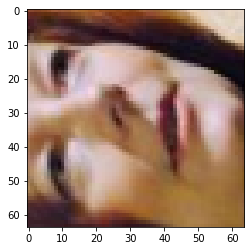

In [6]:
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [7]:
len(train_load)

2771

In [8]:
Encoder=resnet.resnet18()
Encoder.to(device)

Decoder=invresnet.invresnet18()
Decoder.to(device)

Generator=GeneratorNet(Encoder,Decoder)
Generator.to(device)
Discriminator_reconstruct=DiscriminatorNet_reconstruction(3,64)
Discriminator_reconstruct.to(device)

Discriminator_feature=DiscriminatorNet_feature()
Discriminator_feature.to(device)
print("model_loaded")

debug=torch.randn((1,99))
debug.to(device)
Decoder(debug).shape

model_loaded


torch.Size([1, 3, 64, 64])

In [9]:
dr_optimizer = optim.Adam(Discriminator_reconstruct.parameters(), lr=0.00005, betas=(0.5, 0.999))
df_optimizer = optim.Adam(Discriminator_feature.parameters(), lr=0.00005, betas=(0.5, 0.999))
g_optimizer = optim.Adam(Generator.parameters(), lr=0.00005, betas=(0.5, 0.999))
e_optimizer = optim.Adam(Encoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(Decoder.parameters(), lr=0.00005, betas=(0.5, 0.999))
#print("modules Loaded")
num_epochs=40

In [10]:
import time
from torchvision import transforms, utils

In [11]:
def real_data_target(size):
    data = torch.ones(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    data = torch.zeros(size, 1, 8, 8)
    if torch.cuda.is_available(): return data.cuda()
    return data

def real_feature_target(size):
    data = torch.ones(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_feature_target(size):
    data = torch.zeros(size,1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def reconstruction_loss(optimizer,real_data,Generator):
    reconstruction=Generator(real_data)
    loss = nn.L1Loss()
    optimizer.zero_grad()
    error_recons=loss(real_data,reconstruction)*0.9
    error_recons.backward()
    optimizer.step()
    return error_recons
def adv_feature_loss(minimizing,real_feature,fake_feature,Discriminator,optimizer1,optimizer2):
    loss=nn.BCELoss()
    if minimizing:
        optimizer1.zero_grad()
        prediction_real = Discriminator(real_feature)
        error_real = loss(prediction_real, real_feature_target(real_feature.size(0)))
        error_real.backward()   
        
        prediction_fake = Discriminator(fake_feature)
        error_fake = loss(prediction_fake, fake_feature_target(real_feature.size(0)))
        error_fake.backward()
        total_error=error_real+error_fake
        optimizer1.step()    
        return error_real+error_fake
    else:
        optimizer2.zero_grad()
        prediction_fake=Discriminator(fake_feature)
        error_fake = loss(prediction_fake, real_feature_target(real_feature.size(0)))
        error_fake.backward()
        optimizer2.step()    
        return error_fake


def adv_img_loss(minimizing,real_data,fake_data,Discriminator,optimizer1,optimizer2):
    loss = nn.BCELoss()
    def dloss_calc_adv(optimizer, real_data, fake_data,Discriminator):
        
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake
    def gloss_calc_adv(optimizer, real_data,fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_fake=Discriminator(fake_data_target)
        error_fake = loss(prediction_fake, real_data_target(real_data.size(0)))
        error_fake.backward()
        optimizer.step()
       
    if minimizing:
        return dloss_calc_adv(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc_adv(optimizer2,real_data,fake_data,Discriminator)
    
    
def gen_image_loss(minimizing,real_data, fake_data,Discriminator, optimizer1,optimizer2,weight=0.8):
    def dloss_calc(optimizer, real_data, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction_real = Discriminator(real_data)
        error_real = loss(prediction_real, real_data_target(real_data.size(0)))*weight
        error_real.backward()
        prediction_fake = Discriminator(fake_data)
        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))*weight
        error_fake.backward()
        optimizer.step()
        return error_real + error_fake, prediction_real, prediction_fake
    def gloss_calc(optimizer, fake_data,Discriminator):
        optimizer.zero_grad()
        prediction = Discriminator(fake_data)
        error = loss(prediction, real_data_target(prediction.size(0)))*weight
        error.backward()
        optimizer.step()
        return error
    
    loss = nn.BCELoss()
        
    if minimizing:
        return dloss_calc(optimizer1,real_data,fake_data,Discriminator)
    else:
        return gloss_calc(optimizer2,fake_data,Discriminator)

def noise_vector(size):
    n = torch.randn(size,99)
    if torch.cuda.is_available(): return n.cuda() 
    return n

def eval_generate(Decoder,num_images):
    Decoder.eval()
    noi_input=noise_vector(num_images)
    output=Decoder(noi_input)
    output=output.detach().cpu()
    plt.figure(figsize=(16, 16))
    grid_border_size = 2
    grid = utils.make_grid(output)
    
    plt.imshow((grid.numpy().transpose((1, 2, 0))*0.5)+0.5)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
def train(num_epochs,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load):
    t_start = time.time()
    discrim_error=[]
    generator_error=[]
    recons_error=[]
    feature_discrim_error=[]
    encoder_error=[]
    discrim_adv_error=[]
    duration_avg = 0.0
    Encoder.train()
    Decoder.train()
    Generator.train()
    Discriminator_reconstruct.train()
    Discriminator_feature.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):        
 
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            noi = noise_vector(real_images.size(0))

            # 1-1.Train DiscriminatorX with img
            fake_data = Decoder(noi).detach()
            d_error, d_pred_real, d_pred_fake =gen_image_loss(True,real_images.float(), 
                                                              fake_data,Discriminator_reconstruct,
                                                              dr_optimizer,d_optimizer)
            # Train 1-2 GeneratorX
            fake_data = Decoder(noi)#noise(real_batch.size(0)))
            g_error = gen_image_loss(False, real_images.float(), fake_data,
                                    Discriminator_reconstruct,
                                    dr_optimizer,d_optimizer)

            #2 Train DiscriminatorZ
            real_feature=Encoder(real_images.float()).detach()
            df_error_adv=adv_feature_loss(True,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            real_feature=Encoder(real_images.float())
            en_error_adv=adv_feature_loss(False,noi,real_feature,
                                          Discriminator_feature,
                                          df_optimizer,e_optimizer)
            
            
            #3-1 Train DiscriminatorX_adv
            
            fake_data=Generator(real_images.float()).detach()
            d_error1=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            #3-2 Train GeneratorX_adv
            fake_data=Generator(real_images.float())
            g_error2=adv_img_loss(True,real_images.float(),fake_data,
                                  Discriminator_reconstruct,dr_optimizer,g_optimizer)
            # 4. Train Reconstruction
            
            recons_loss=reconstruction_loss(g_optimizer,real_images.float(),Generator)
            
            
            # Display Progress
            if (batch_i) % 300 == 0:
                print("Batch: ", batch_i)
                print("1:Discriminator_Error: ", d_error.item()," Generator_Error: ", g_error.item()," Recons_Error: ", recons_loss.item())
                print("2:Feature Discriminator Error: ",df_error_adv.item(),"Encoder Error: ", en_error_adv.item())
                print("3 Discriminator_adv_error", d_error1.item(), "Generator_error: ", g_error2.item())
                discrim_error.append(d_error.item())
                generator_error.append((float(g_error.item())+float(g_error2.item()))/2)
                recons_error.append(recons_loss.item())
                feature_discrim_error.append(df_error_adv.item())
                encoder_error.append(en_error_adv.item())
                discrim_adv_error.append(d_error1.item())
            
    
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
        torch.save(Encoder,'Encoder_64batch.h')
        torch.save(Decoder,'Decoder_64batch.h')
        torch.save(Discriminator_feature,'Discriminator_feature_64batch.h')
        torch.save(Discriminator_reconstruct,'Discriminator_reconstruct_64batch.h')
        eval_generate(Decoder,8)
        

Epoch: 0
Batch:  0
1:Discriminator_Error:  1.130950689315796  Generator_Error:  0.5702967643737793  Recons_Error:  0.6744474768638611
2:Feature Discriminator Error:  1.396565556526184 Encoder Error:  0.6421494483947754
3 Discriminator_adv_error 1.407846450805664 Generator_error:  1.4037532806396484
Batch:  300
1:Discriminator_Error:  1.2244701385498047  Generator_Error:  0.38276243209838867  Recons_Error:  0.17577455937862396
2:Feature Discriminator Error:  1.4300966262817383 Encoder Error:  0.6738697290420532
3 Discriminator_adv_error 0.8779616951942444 Generator_error:  0.8702263832092285
Batch:  600
1:Discriminator_Error:  1.387014627456665  Generator_Error:  0.34075483679771423  Recons_Error:  0.1758192479610443
2:Feature Discriminator Error:  1.4275312423706055 Encoder Error:  0.7006374597549438
3 Discriminator_adv_error 0.8151172995567322 Generator_error:  0.8653032183647156
Batch:  900
1:Discriminator_Error:  1.0857810974121094  Generator_Error:  0.3971523940563202  Recons_Error

/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won'

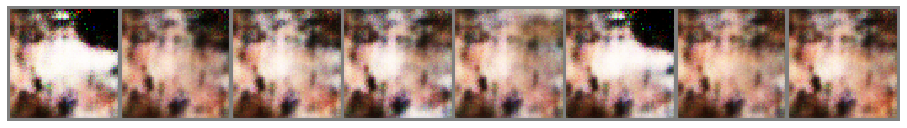

Epoch: 1
Batch:  0
1:Discriminator_Error:  1.0227270126342773  Generator_Error:  0.4670479893684387  Recons_Error:  0.20469635725021362
2:Feature Discriminator Error:  1.4086663722991943 Encoder Error:  0.6922354698181152
3 Discriminator_adv_error 0.49386346340179443 Generator_error:  0.4575100541114807
Batch:  300
1:Discriminator_Error:  1.1312720775604248  Generator_Error:  0.35558873414993286  Recons_Error:  0.14506644010543823
2:Feature Discriminator Error:  1.4009754657745361 Encoder Error:  0.683592677116394
3 Discriminator_adv_error 0.4522096514701843 Generator_error:  0.4403432607650757
Batch:  600
1:Discriminator_Error:  1.316904067993164  Generator_Error:  0.30217036604881287  Recons_Error:  0.11873850971460342
2:Feature Discriminator Error:  1.4080784320831299 Encoder Error:  0.7081238627433777
3 Discriminator_adv_error 0.5036393404006958 Generator_error:  0.46153464913368225
Batch:  900
1:Discriminator_Error:  1.2817463874816895  Generator_Error:  0.2695988118648529  Recons

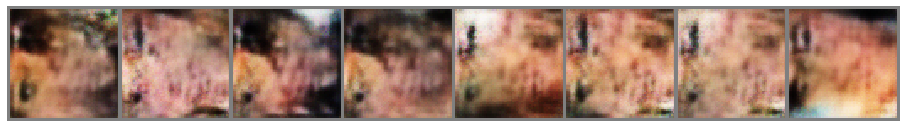

Epoch: 2
Batch:  0
1:Discriminator_Error:  1.3089604377746582  Generator_Error:  0.2647908627986908  Recons_Error:  0.1094067394733429
2:Feature Discriminator Error:  1.3710837364196777 Encoder Error:  0.6817218065261841
3 Discriminator_adv_error 0.3165872395038605 Generator_error:  0.2949008047580719
Batch:  300
1:Discriminator_Error:  1.2982364892959595  Generator_Error:  0.2916356325149536  Recons_Error:  0.1053139865398407
2:Feature Discriminator Error:  1.3777902126312256 Encoder Error:  0.6986249685287476
3 Discriminator_adv_error 0.3449043035507202 Generator_error:  0.33191341161727905
Batch:  600
1:Discriminator_Error:  1.2081142663955688  Generator_Error:  0.3810257017612457  Recons_Error:  0.10858461260795593
2:Feature Discriminator Error:  1.3981835842132568 Encoder Error:  0.6963680982589722
3 Discriminator_adv_error 0.3613339960575104 Generator_error:  0.3533114194869995
Batch:  900
1:Discriminator_Error:  1.3190289735794067  Generator_Error:  0.2680477499961853  Recons_Er

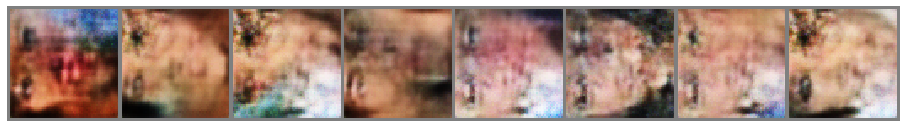

Epoch: 3
Batch:  0
1:Discriminator_Error:  1.3310356140136719  Generator_Error:  0.35264667868614197  Recons_Error:  0.10348144173622131
2:Feature Discriminator Error:  1.3990767002105713 Encoder Error:  0.7007134556770325
3 Discriminator_adv_error 0.518484354019165 Generator_error:  0.44251683354377747
Batch:  300
1:Discriminator_Error:  1.3692150115966797  Generator_Error:  0.2524806261062622  Recons_Error:  0.09651380032300949
2:Feature Discriminator Error:  1.3799594640731812 Encoder Error:  0.6958780288696289
3 Discriminator_adv_error 0.31338778138160706 Generator_error:  0.30236074328422546
Batch:  600
1:Discriminator_Error:  1.3473927974700928  Generator_Error:  0.2657591998577118  Recons_Error:  0.09784477204084396
2:Feature Discriminator Error:  1.3807237148284912 Encoder Error:  0.6892135143280029
3 Discriminator_adv_error 0.3075298070907593 Generator_error:  0.3021529018878937
Batch:  900
1:Discriminator_Error:  1.3556811809539795  Generator_Error:  0.2688696086406708  Recon

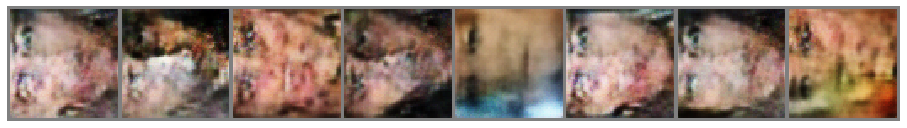

Epoch: 4
Batch:  0
1:Discriminator_Error:  1.335273265838623  Generator_Error:  0.2899533808231354  Recons_Error:  0.10434115678071976
2:Feature Discriminator Error:  1.3739752769470215 Encoder Error:  0.6954430341720581
3 Discriminator_adv_error 0.276269793510437 Generator_error:  0.2691210210323334
Batch:  300
1:Discriminator_Error:  1.3010437488555908  Generator_Error:  0.28280290961265564  Recons_Error:  0.0948474109172821
2:Feature Discriminator Error:  1.3804831504821777 Encoder Error:  0.6975136995315552
3 Discriminator_adv_error 0.2820288836956024 Generator_error:  0.2699470818042755
Batch:  600
1:Discriminator_Error:  1.357529640197754  Generator_Error:  0.25067421793937683  Recons_Error:  0.09806960821151733
2:Feature Discriminator Error:  1.3912827968597412 Encoder Error:  0.7036834955215454
3 Discriminator_adv_error 0.29826581478118896 Generator_error:  0.28912994265556335
Batch:  900
1:Discriminator_Error:  1.3132054805755615  Generator_Error:  0.2597585916519165  Recons_E

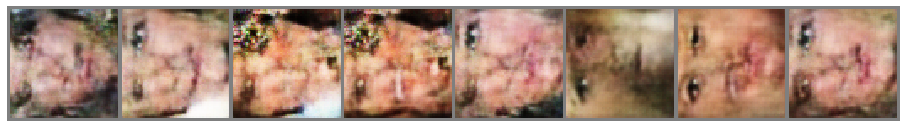

Epoch: 5
Batch:  0
1:Discriminator_Error:  1.3325037956237793  Generator_Error:  0.28451716899871826  Recons_Error:  0.10089176893234253
2:Feature Discriminator Error:  1.381927728652954 Encoder Error:  0.6997717022895813
3 Discriminator_adv_error 0.3195459842681885 Generator_error:  0.3003891706466675
Batch:  300
1:Discriminator_Error:  1.4129292964935303  Generator_Error:  0.25902116298675537  Recons_Error:  0.09648068994283676
2:Feature Discriminator Error:  1.3860806226730347 Encoder Error:  0.6916442513465881
3 Discriminator_adv_error 0.3686484396457672 Generator_error:  0.30923664569854736
Batch:  600
1:Discriminator_Error:  1.6041131019592285  Generator_Error:  0.2092539519071579  Recons_Error:  0.09543029963970184
2:Feature Discriminator Error:  1.377853274345398 Encoder Error:  0.6951345801353455
3 Discriminator_adv_error 0.3264198303222656 Generator_error:  0.3150373697280884
Batch:  900
1:Discriminator_Error:  1.2750778198242188  Generator_Error:  0.3021598756313324  Recons_

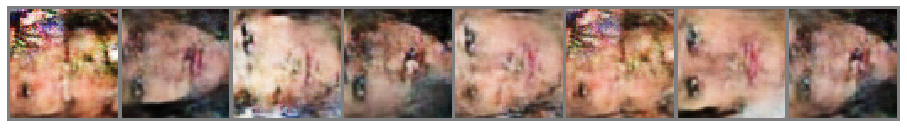

Epoch: 6
Batch:  0
1:Discriminator_Error:  1.3749417066574097  Generator_Error:  0.25479066371917725  Recons_Error:  0.10329721868038177
2:Feature Discriminator Error:  1.3845863342285156 Encoder Error:  0.6918979287147522
3 Discriminator_adv_error 0.3027290999889374 Generator_error:  0.27531152963638306
Batch:  300
1:Discriminator_Error:  1.2756965160369873  Generator_Error:  0.28165504336357117  Recons_Error:  0.0888710469007492
2:Feature Discriminator Error:  1.3819403648376465 Encoder Error:  0.6895945072174072
3 Discriminator_adv_error 0.28865543007850647 Generator_error:  0.2772308588027954
Batch:  600
1:Discriminator_Error:  1.318410038948059  Generator_Error:  0.39403268694877625  Recons_Error:  0.09509313106536865
2:Feature Discriminator Error:  1.3868060111999512 Encoder Error:  0.6972121000289917
3 Discriminator_adv_error 0.31210875511169434 Generator_error:  0.2975369393825531
Batch:  900
1:Discriminator_Error:  1.3625863790512085  Generator_Error:  0.24913696944713593  Rec

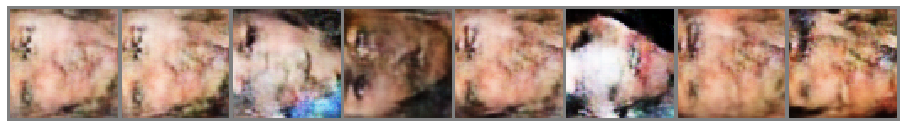

Epoch: 7
Batch:  0
1:Discriminator_Error:  1.358133316040039  Generator_Error:  0.3289732038974762  Recons_Error:  0.0909820944070816
2:Feature Discriminator Error:  1.3845868110656738 Encoder Error:  0.6955742835998535
3 Discriminator_adv_error 0.3457663357257843 Generator_error:  0.33415916562080383
Batch:  300
1:Discriminator_Error:  1.2977696657180786  Generator_Error:  0.2824417054653168  Recons_Error:  0.0873524621129036
2:Feature Discriminator Error:  1.383018136024475 Encoder Error:  0.6938260793685913
3 Discriminator_adv_error 0.2570441663265228 Generator_error:  0.25391292572021484
Batch:  600
1:Discriminator_Error:  1.4672086238861084  Generator_Error:  0.28783684968948364  Recons_Error:  0.08690854161977768
2:Feature Discriminator Error:  1.3837891817092896 Encoder Error:  0.6926378607749939
3 Discriminator_adv_error 0.33570927381515503 Generator_error:  0.2688521146774292
Batch:  900
1:Discriminator_Error:  1.2780550718307495  Generator_Error:  0.31461814045906067  Recons_

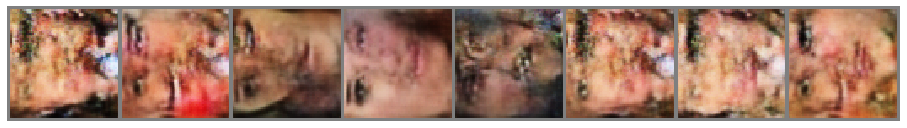

Epoch: 8
Batch:  0
1:Discriminator_Error:  1.3090323209762573  Generator_Error:  0.4448776841163635  Recons_Error:  0.08517138659954071
2:Feature Discriminator Error:  1.3896911144256592 Encoder Error:  0.6999211311340332
3 Discriminator_adv_error 0.5062282681465149 Generator_error:  0.35910969972610474
Batch:  300
1:Discriminator_Error:  1.1832678318023682  Generator_Error:  0.3904465436935425  Recons_Error:  0.0836450457572937
2:Feature Discriminator Error:  1.3975110054016113 Encoder Error:  0.6997474431991577
3 Discriminator_adv_error 0.33712083101272583 Generator_error:  0.3001869022846222
Batch:  600
1:Discriminator_Error:  1.312445878982544  Generator_Error:  0.27088090777397156  Recons_Error:  0.08412283658981323
2:Feature Discriminator Error:  1.3878700733184814 Encoder Error:  0.6925897598266602
3 Discriminator_adv_error 0.27129819989204407 Generator_error:  0.2657947540283203
Batch:  900
1:Discriminator_Error:  1.3494553565979004  Generator_Error:  0.25945475697517395  Recon

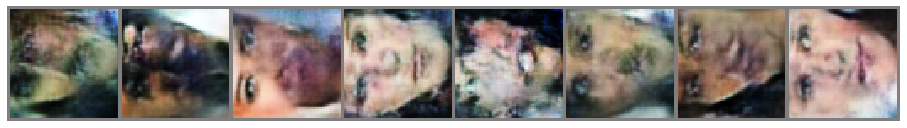

Epoch: 9
Batch:  0
1:Discriminator_Error:  1.0820780992507935  Generator_Error:  0.4007541835308075  Recons_Error:  0.1099511981010437
2:Feature Discriminator Error:  1.382565975189209 Encoder Error:  0.6945028305053711
3 Discriminator_adv_error 0.30424654483795166 Generator_error:  0.2935525178909302
Batch:  300
1:Discriminator_Error:  1.2777678966522217  Generator_Error:  0.4183362126350403  Recons_Error:  0.0839250236749649
2:Feature Discriminator Error:  1.3886184692382812 Encoder Error:  0.690521240234375
3 Discriminator_adv_error 0.3224322199821472 Generator_error:  0.2901369631290436
Batch:  600
1:Discriminator_Error:  1.329094409942627  Generator_Error:  0.2671968936920166  Recons_Error:  0.08236584812402725
2:Feature Discriminator Error:  1.3937294483184814 Encoder Error:  0.691199541091919
3 Discriminator_adv_error 0.2803494930267334 Generator_error:  0.2741853594779968
Batch:  900
1:Discriminator_Error:  1.318643569946289  Generator_Error:  0.27421513199806213  Recons_Error:

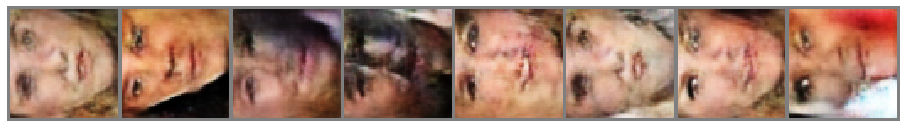

Epoch: 10
Batch:  0
1:Discriminator_Error:  1.330536127090454  Generator_Error:  0.2652725279331207  Recons_Error:  0.0855741798877716
2:Feature Discriminator Error:  1.3854396343231201 Encoder Error:  0.7014138698577881
3 Discriminator_adv_error 0.2709130048751831 Generator_error:  0.2667270004749298
Batch:  300
1:Discriminator_Error:  1.3115406036376953  Generator_Error:  0.2804889976978302  Recons_Error:  0.08624500036239624
2:Feature Discriminator Error:  1.3823108673095703 Encoder Error:  0.6906659007072449
3 Discriminator_adv_error 0.2818347215652466 Generator_error:  0.25292500853538513
Batch:  600
1:Discriminator_Error:  1.3584027290344238  Generator_Error:  0.26103243231773376  Recons_Error:  0.07993214577436447
2:Feature Discriminator Error:  1.3902246952056885 Encoder Error:  0.6891670227050781
3 Discriminator_adv_error 0.2932731807231903 Generator_error:  0.2752939462661743
Batch:  900
1:Discriminator_Error:  1.3306690454483032  Generator_Error:  0.25227829813957214  Recons

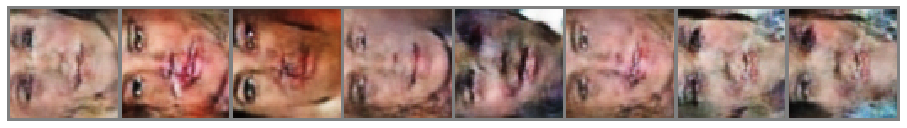

Epoch: 11
Batch:  0
1:Discriminator_Error:  1.2782708406448364  Generator_Error:  0.3025040328502655  Recons_Error:  0.093586765229702
2:Feature Discriminator Error:  1.380180835723877 Encoder Error:  0.6933180093765259
3 Discriminator_adv_error 0.33162954449653625 Generator_error:  0.30382460355758667
Batch:  300
1:Discriminator_Error:  1.3543728590011597  Generator_Error:  0.23448829352855682  Recons_Error:  0.07734116911888123
2:Feature Discriminator Error:  1.3899028301239014 Encoder Error:  0.698494017124176
3 Discriminator_adv_error 0.2050129622220993 Generator_error:  0.19859923422336578
Batch:  600
1:Discriminator_Error:  1.3299920558929443  Generator_Error:  0.25197502970695496  Recons_Error:  0.07797149568796158
2:Feature Discriminator Error:  1.391244888305664 Encoder Error:  0.695791482925415
3 Discriminator_adv_error 0.24501082301139832 Generator_error:  0.24083808064460754
Batch:  900
1:Discriminator_Error:  1.3587853908538818  Generator_Error:  0.2554384469985962  Recons

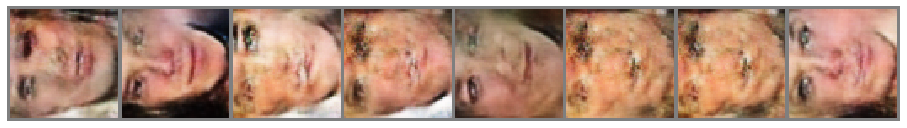

Epoch: 12
Batch:  0
1:Discriminator_Error:  1.4296773672103882  Generator_Error:  0.2532189190387726  Recons_Error:  0.08494273573160172
2:Feature Discriminator Error:  1.3853070735931396 Encoder Error:  0.7006715536117554
3 Discriminator_adv_error 0.3318394124507904 Generator_error:  0.297065794467926
Batch:  300
1:Discriminator_Error:  1.339072823524475  Generator_Error:  0.2668038308620453  Recons_Error:  0.08128312230110168
2:Feature Discriminator Error:  1.3790652751922607 Encoder Error:  0.6995490193367004
3 Discriminator_adv_error 0.2793867588043213 Generator_error:  0.2701389491558075
Batch:  600
1:Discriminator_Error:  1.3693537712097168  Generator_Error:  0.23301084339618683  Recons_Error:  0.0787709504365921
2:Feature Discriminator Error:  1.3823590278625488 Encoder Error:  0.6922587752342224
3 Discriminator_adv_error 0.25674664974212646 Generator_error:  0.25156456232070923
Batch:  900
1:Discriminator_Error:  1.360834002494812  Generator_Error:  0.24499289691448212  Recons_

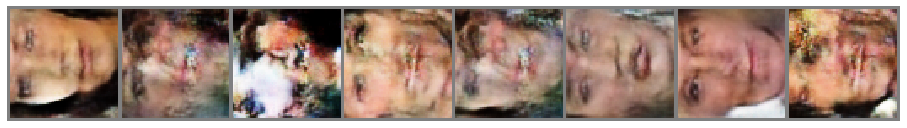

Epoch: 13
Batch:  0
1:Discriminator_Error:  1.30953049659729  Generator_Error:  0.2853389382362366  Recons_Error:  0.0808766633272171
2:Feature Discriminator Error:  1.3905376195907593 Encoder Error:  0.7044146656990051
3 Discriminator_adv_error 0.26781779527664185 Generator_error:  0.2608289420604706
Batch:  300
1:Discriminator_Error:  1.3647637367248535  Generator_Error:  0.2545320689678192  Recons_Error:  0.0784020945429802
2:Feature Discriminator Error:  1.3889394998550415 Encoder Error:  0.6987494230270386
3 Discriminator_adv_error 0.2727676331996918 Generator_error:  0.2667964696884155
Batch:  600
1:Discriminator_Error:  1.3810620307922363  Generator_Error:  0.27987974882125854  Recons_Error:  0.08487103134393692
2:Feature Discriminator Error:  1.3855459690093994 Encoder Error:  0.7009340524673462
3 Discriminator_adv_error 0.2960716187953949 Generator_error:  0.2766522467136383
Batch:  900
1:Discriminator_Error:  1.1734447479248047  Generator_Error:  0.35208266973495483  Recons_E

In [ ]:
train(40,Encoder,Decoder,Generator,Discriminator_reconstruct,Discriminator_feature,d_optimizer,dr_optimizer,g_optimizer,train_load)

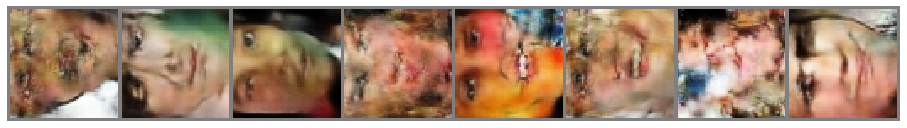

In [32]:
torch.save(Encoder,'Encoder_64batch.h')
torch.save(Decoder,'Decoder_64batch.h')
torch.save(Discriminator_feature,'Discriminator_feature_64batch.h')
torch.save(Discriminator_reconstruct,'Discriminator_reconstruct_64batch.h')
eval_generate(Decoder,8)
        

In [ ]:
1